<a href="https://colab.research.google.com/github/nguyenduongtri5703/sugarcane_leaf_disease_classification/blob/main/Sugarcan_Leaf_Disease_With_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from PIL import Image
import os
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from keras.metrics import Precision, Recall
import tensorflow as tf
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
print(tf.__version__)

2.17.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/model_history'

Mounted at /content/gdrive
/content/gdrive/MyDrive/model_history


In [ ]:
!ls /content/gdrive/MyDrive/dataset/

countries.csv	      dataset2_train.csv   dataset42.csv	     tennis_test.csv
credit.csv	      dataset3.csv	   dataset4.csv		     tennis_train.csv
dataset1_apriori.csv  dataset3_danchu.csv  iris.csv		     titanic.csv
dataset1.csv	      dataset3_test.csv    salary.csv
dataset2.csv	      dataset3_train.csv   students.csv
dataset2_test.csv     dataset41.csv	   SugarcaneLeafDataset.zip


In [ ]:
# Tạo thư mục tạm thời
!mkdir /content/sugarcane_leaf_dataset

# Giải nén vào thư mục tạm thời
!unzip /content/gdrive/MyDrive/dataset/SugarcaneLeafDataset.zip -d /content/sugarcane_leaf_dataset

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: /content/sugarcane_leaf_dataset/SugarcaneLeafDataset/Brown Spot/image564.jpg  
  inflating: /content/sugarcane_leaf_dataset/SugarcaneLeafDataset/Brown Spot/image565.jpg  
  inflating: /content/sugarcane_leaf_dataset/SugarcaneLeafDataset/Brown Spot/image566.jpg  
  inflating: /content/sugarcane_leaf_dataset/SugarcaneLeafDataset/Brown Spot/image567.jpg  
  inflating: /content/sugarcane_leaf_dataset/SugarcaneLeafDataset/Brown Spot/image568.jpg  
  inflating: /content/sugarcane_leaf_dataset/SugarcaneLeafDataset/Brown Spot/image569.jpg  
  inflating: /content/sugarcane_leaf_dataset/SugarcaneLeafDataset/Brown Spot/image570.jpg  
  inflating: /content/sugarcane_leaf_dataset/SugarcaneLeafDataset/Brown Spot/image571.jpg  
  inflating: /content/sugarcane_leaf_dataset/SugarcaneLeafDataset/Brown Spot/image572.jpg  
  inflating: /content/sugarcane_leaf_dataset/SugarcaneLeafDataset/Brown Spot/image573.jpg  
  inflating: /content/s

In [ ]:
# Cài đặt thư viện split-folders
!pip install split-folders

import splitfolders

# Đường dẫn đến thư mục chứa hình ảnh
input_folder = '/content/sugarcane_leaf_dataset/SugarcaneLeafDataset'
output_folder = '/content/sugarcane'  # Thư mục đầu ra

# Chia dữ liệu theo tỷ lệ 80% cho train, 10% cho validation, 10% cho test
splitfolders.ratio(input_folder, output=output_folder, ratio=(.8, .1, .1), seed=42)

Copying files: 6748 files [00:02, 2375.90 files/s]


In [ ]:
# Đường dẫn đến thư mục sau khi chia dữ liệu
output_folder = '/content/sugarcane'

# Hàm đếm số lượng hình ảnh trong từng lớp của từng tập dữ liệu
def count_images_in_folder(folder_path):
    for dataset_type in ['train', 'val', 'test']:
        print(f"\nSố lượng hình ảnh trong tập {dataset_type}:")
        dataset_path = os.path.join(folder_path, dataset_type)
        for class_folder in os.listdir(dataset_path):
            class_path = os.path.join(dataset_path, class_folder)
            if os.path.isdir(class_path):  # Kiểm tra nếu đây là thư mục
                num_images = len(os.listdir(class_path))
                print(f"  - Lớp {class_folder}: {num_images} hình ảnh")

# Gọi hàm để đếm hình ảnh
count_images_in_folder(output_folder)


Số lượng hình ảnh trong tập train:
  - Lớp Yellow Leaf: 955 hình ảnh
  - Lớp Viral Disease: 530 hình ảnh
  - Lớp Pokkah Boeng: 237 hình ảnh
  - Lớp Brown Spot: 1377 hình ảnh
  - Lớp BrownRust: 251 hình ảnh
  - Lớp Grassy shoot: 276 hình ảnh
  - Lớp Dried Leaves: 274 hình ảnh
  - Lớp Healthy Leaves: 344 hình ảnh
  - Lớp Banded Chlorosis: 376 hình ảnh
  - Lớp smut: 252 hình ảnh
  - Lớp Sett Rot: 521 hình ảnh

Số lượng hình ảnh trong tập val:
  - Lớp Yellow Leaf: 119 hình ảnh
  - Lớp Viral Disease: 66 hình ảnh
  - Lớp Pokkah Boeng: 29 hình ảnh
  - Lớp Brown Spot: 172 hình ảnh
  - Lớp BrownRust: 31 hình ảnh
  - Lớp Grassy shoot: 34 hình ảnh
  - Lớp Dried Leaves: 34 hình ảnh
  - Lớp Healthy Leaves: 43 hình ảnh
  - Lớp Banded Chlorosis: 47 hình ảnh
  - Lớp smut: 31 hình ảnh
  - Lớp Sett Rot: 65 hình ảnh

Số lượng hình ảnh trong tập test:
  - Lớp Yellow Leaf: 120 hình ảnh
  - Lớp Viral Disease: 67 hình ảnh
  - Lớp Pokkah Boeng: 31 hình ảnh
  - Lớp Brown Spot: 173 hình ảnh
  - Lớp BrownRust: 

In [ ]:
image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
# Cấu hình ImageDataGenerator với các kỹ thuật tăng cường
train_datagen = ImageDataGenerator(
    rescale=1./255,                  # Chuẩn hóa giá trị pixel về khoảng [0, 1]
    rotation_range=30,               # Xoay ảnh ngẫu nhiên trong khoảng 0 - 30 độ
    width_shift_range=0.2,           # Dịch chuyển ngang ngẫu nhiên 20%
    height_shift_range=0.2,          # Dịch chuyển dọc ngẫu nhiên 20%
    shear_range=0.2,                 # Phép biến dạng (shear) ảnh ngẫu nhiên
    zoom_range=0.2,                  # Phóng to/thu nhỏ ảnh ngẫu nhiên
    horizontal_flip=True,            # Lật ngang ngẫu nhiên
    fill_mode='nearest'              # Điền giá trị vào các vùng trống khi xoay hoặc dịch chuyển
)
train_loader = train_datagen.flow_from_directory(
    directory = "/content/sugarcane/train",
    target_size = (224, 224),
    batch_size = 32,
    shuffle = True
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_loader = val_datagen.flow_from_directory(
    directory="/content/sugarcane/val",
    target_size=(224, 224),
    batch_size=32,
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_loader = test_datagen.flow_from_directory(
    directory="/content/sugarcane/test",
    target_size=(224, 224),
    batch_size=32,
    shuffle=False
)

Found 5393 images belonging to 11 classes.
Found 671 images belonging to 11 classes.
Found 684 images belonging to 11 classes.


In [ ]:
train_loader.class_indices

{'Banded Chlorosis': 0,
 'Brown Spot': 1,
 'BrownRust': 2,
 'Dried Leaves': 3,
 'Grassy shoot': 4,
 'Healthy Leaves': 5,
 'Pokkah Boeng': 6,
 'Sett Rot': 7,
 'Viral Disease': 8,
 'Yellow Leaf': 9,
 'smut': 10}

In [ ]:
idx_to_class = {val:key for key, val in dict(train_loader.class_indices).items()}
idx_to_class

{0: 'Banded Chlorosis',
 1: 'Brown Spot',
 2: 'BrownRust',
 3: 'Dried Leaves',
 4: 'Grassy shoot',
 5: 'Healthy Leaves',
 6: 'Pokkah Boeng',
 7: 'Sett Rot',
 8: 'Viral Disease',
 9: 'Yellow Leaf',
 10: 'smut'}

In [ ]:
model = Sequential()
model.add(VGG16(include_top=False, pooling="avg"))
model.add(Dense(11, activation = "softmax"))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.layers[0].trainable = False

In [ ]:
# Compile model với accuracy
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
steps_train = int(np.ceil(train_loader.samples / train_loader.batch_size))
steps_test = int(np.ceil(test_loader.samples / test_loader.batch_size))
print(steps_train)
print(steps_test)

169
22


In [ ]:
# Đường dẫn đầy đủ để lưu checkpoint
checkpoint_path = '/content/gdrive/MyDrive/model_history/model_checkpoint.keras'  # Đổi thành .keras

# Cấu hình ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',            # Hoặc 'val_accuracy' tùy theo tiêu chí bạn muốn theo dõi
    save_best_only=False,          # Lưu lại model mỗi epoch
    save_weights_only=False,       # Lưu toàn bộ mô hình
    verbose=1                      # In ra thông báo khi lưu checkpoint
)

In [ ]:
# Khi training, thêm callback này vào model.fit()
model_history = model.fit(
    train_loader,
    epochs=20,
    validation_data=val_loader,
    callbacks=[checkpoint_callback]
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.2833 - loss: 2.0516 
Epoch 1: saving model to /content/gdrive/MyDrive/model_history/model_checkpoint.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 3746s 22s/step - accuracy: 0.2836 - loss: 2.0509 - val_accuracy: 0.4128 - val_loss: 1.7173
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.4364 - loss: 1.7136 
Epoch 2: saving model to /content/gdrive/MyDrive/model_history/model_checkpoint.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 3664s 22s/step - accuracy: 0.4365 - loss: 1.7133 - val_accuracy: 0.4560 - val_loss: 1.5590
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.4628 - loss: 1.5910 
Epoch 3: saving model to /content/gdrive/MyDrive/model_history/model_checkpoint.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 3639s 22s/step - accuracy: 0.4630 - loss: 1.5907 - val_accuracy: 0.4963 - val_loss: 1.4506
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.5135 - loss: 1.4737 
Epoch 4: saving model to /content/gdrive/MyDr

In [ ]:
# Bước 1: Xây dựng lại mô hình
model_vgg16 = Sequential()
model_vgg16.add(VGG16(include_top=False, pooling="avg", input_shape=(224, 224, 3)))  # Đảm bảo kích thước đầu vào chính xác
model_vgg16.add(Dense(11, activation="softmax"))  # Thay đổi số lớp đầu ra

# Bước 2: Khóa các lớp không cần thiết
model_vgg16.layers[0].trainable = False

# Bước 3: Biên dịch mô hình
model_vgg16.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Bước 4: Xây dựng mô hình để nó có thể tải trọng số
model_vgg16.build((None, 224, 224, 3))  # Xây dựng mô hình với kích thước đầu vào

# Bước 5: Tải trọng số từ mô hình đã lưu
model_vgg16.load_weights('/content/gdrive/MyDrive/model_history/model_checkpoint.keras')

# Bước 6: Kiểm tra mô hình
model_vgg16.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 512)                 │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │           5,643 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,720,331 (56.15 MB)

 Trainable params: 5,643 (22.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Đường dẫn mới để lưu checkpoint, nếu muốn tránh ghi đè
checkpoint_path = '/content/gdrive/MyDrive/model_history/model_checkpoint_v2.keras'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=False,
    verbose=1
)

In [ ]:
# Bây giờ bạn có thể tiếp tục huấn luyện mô hình mới này
model_history = model_vgg16.fit(
    train_loader,
    epochs=9,  # Số lượng epoch bạn muốn tiếp tục
    validation_data=val_loader,
    callbacks=[checkpoint_callback]  # Nếu bạn có callback để lưu lại
)

Epoch 1/9
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.6064 - loss: 1.1439 
Epoch 1: saving model to /content/gdrive/MyDrive/model_history/model_checkpoint_v2.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 3922s 23s/step - accuracy: 0.6064 - loss: 1.1438 - val_accuracy: 0.6244 - val_loss: 1.0989
Epoch 2/9
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.6129 - loss: 1.1241 
Epoch 2: saving model to /content/gdrive/MyDrive/model_history/model_checkpoint_v2.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 3931s 23s/step - accuracy: 0.6130 - loss: 1.1241 - val_accuracy: 0.6259 - val_loss: 1.0764
Epoch 3/9
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.6274 - loss: 1.1012 
Epoch 3: saving model to /content/gdrive/MyDrive/model_history/model_checkpoint_v2.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 3908s 23s/step - accuracy: 0.6274 - loss: 1.1011 - val_accuracy: 0.6528 - val_loss: 1.0477
Epoch 4/9
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.6354 - loss: 1.0745 
Epoch 4: saving model to /con

In [ ]:
# Bước 1: Xây dựng lại mô hình
model_vgg16 = Sequential()
model_vgg16.add(VGG16(include_top=False, pooling="avg", input_shape=(224, 224, 3)))  # Đảm bảo kích thước đầu vào chính xác
model_vgg16.add(Dense(11, activation="softmax"))  # Thay đổi số lớp đầu ra

# Bước 2: Khóa các lớp không cần thiết
model_vgg16.layers[0].trainable = False

# Bước 3: Biên dịch mô hình
model_vgg16.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Bước 4: Xây dựng mô hình để nó có thể tải trọng số
model_vgg16.build((None, 224, 224, 3))  # Xây dựng mô hình với kích thước đầu vào

# Bước 5: Tải trọng số từ mô hình đã lưu
model_vgg16.load_weights('/content/gdrive/MyDrive/model_history/model_checkpoint_v2.keras')

# Bước 6: Kiểm tra mô hình
model_vgg16.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 512)                 │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 11)                  │           5,643 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,720,331 (56.15 MB)

 Trainable params: 5,643 (22.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Đường dẫn mới để lưu checkpoint, nếu muốn tránh ghi đè
checkpoint_path = '/content/gdrive/MyDrive/model_history/model_checkpoint_v3.keras'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=False,
    verbose=1
)

In [ ]:
# Bây giờ bạn có thể tiếp tục huấn luyện mô hình mới này
model_history = model_vgg16.fit(
    train_loader,
    epochs= 3,  # Số lượng epoch bạn muốn tiếp tục
    validation_data=val_loader,
    callbacks=[checkpoint_callback]  # Nếu bạn có callback để lưu lại
)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.6729 - loss: 1.0097 
Epoch 1: saving model to /content/gdrive/MyDrive/model_history/model_checkpoint_v3.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 4063s 24s/step - accuracy: 0.6728 - loss: 1.0098 - val_accuracy: 0.6796 - val_loss: 0.9871
Epoch 2/3
 44/169 ━━━━━━━━━━━━━━━━━━━━ 43:42 21s/step - accuracy: 0.6608 - loss: 0.9895

In [ ]:
# Bước 1: Xây dựng lại mô hình
model_vgg16 = Sequential()
model_vgg16.add(VGG16(include_top=False, pooling="avg", input_shape=(224, 224, 3)))  # Đảm bảo kích thước đầu vào chính xác
model_vgg16.add(Dense(11, activation="softmax"))  # Thay đổi số lớp đầu ra

# Bước 2: Khóa các lớp không cần thiết
model_vgg16.layers[0].trainable = False

# Bước 3: Biên dịch mô hình
model_vgg16.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Bước 4: Xây dựng mô hình để nó có thể tải trọng số
model_vgg16.build((None, 224, 224, 3))  # Xây dựng mô hình với kích thước đầu vào

# Bước 5: Tải trọng số từ mô hình đã lưu
model_vgg16.load_weights('/content/gdrive/MyDrive/model_history/model_checkpoint_v3.keras')

# Bước 6: Kiểm tra mô hình
model_vgg16.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 512)                 │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 11)                  │           5,643 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,720,331 (56.15 MB)

 Trainable params: 5,643 (22.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Đường dẫn mới để lưu checkpoint, nếu muốn tránh ghi đè
checkpoint_path = '/content/gdrive/MyDrive/model_history/model_checkpoint_v4.keras'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=False,
    verbose=1
)

In [ ]:
# Bây giờ bạn có thể tiếp tục huấn luyện mô hình mới này
model_history = model_vgg16.fit(
    train_loader,
    epochs= 2,  # Số lượng epoch bạn muốn tiếp tục
    validation_data=val_loader,
    callbacks=[checkpoint_callback]  # Nếu bạn có callback để lưu lại
)

Epoch 1/2
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.6661 - loss: 0.9871 
Epoch 1: saving model to /content/gdrive/MyDrive/model_history/model_checkpoint_v4.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 4219s 25s/step - accuracy: 0.6661 - loss: 0.9871 - val_accuracy: 0.6826 - val_loss: 0.9529
Epoch 2/2
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.6777 - loss: 0.9595 
Epoch 2: saving model to /content/gdrive/MyDrive/model_history/model_checkpoint_v4.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 4258s 25s/step - accuracy: 0.6776 - loss: 0.9596 - val_accuracy: 0.6900 - val_loss: 0.9476


In [ ]:
# Bước 1: Xây dựng lại mô hình
model_vgg16 = Sequential()
model_vgg16.add(VGG16(include_top=False, pooling="avg", input_shape=(224, 224, 3)))  # Đảm bảo kích thước đầu vào chính xác
model_vgg16.add(Dense(11, activation="softmax"))  # Thay đổi số lớp đầu ra

# Bước 2: Khóa các lớp không cần thiết
model_vgg16.layers[0].trainable = False

# Bước 3: Biên dịch mô hình
model_vgg16.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Bước 4: Xây dựng mô hình để nó có thể tải trọng số
model_vgg16.build((None, 224, 224, 3))  # Xây dựng mô hình với kích thước đầu vào

# Bước 5: Tải trọng số từ mô hình đã lưu
model_vgg16.load_weights('/content/gdrive/MyDrive/model_history/model_checkpoint_v4.keras')

# Bước 6: Kiểm tra mô hình
model_vgg16.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 512)                 │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 11)                  │           5,643 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,720,331 (56.15 MB)

 Trainable params: 5,643 (22.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Đường dẫn mới để lưu checkpoint, nếu muốn tránh ghi đè
checkpoint_path = '/content/gdrive/MyDrive/model_history/model_checkpoint_v5.keras'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=False,
    verbose=1
)

In [ ]:
# Bây giờ bạn có thể tiếp tục huấn luyện mô hình mới này
model_history = model_vgg16.fit(
    train_loader,
    epochs= 10,  # Số lượng epoch bạn muốn tiếp tục
    validation_data=val_loader,
    callbacks=[checkpoint_callback]  # Nếu bạn có callback để lưu lại
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.6715 - loss: 0.9713 
Epoch 1: saving model to /content/gdrive/MyDrive/model_history/model_checkpoint_v5.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 3551s 21s/step - accuracy: 0.6715 - loss: 0.9713 - val_accuracy: 0.6692 - val_loss: 0.9386
Epoch 2/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.6658 - loss: 0.9702 
Epoch 2: saving model to /content/gdrive/MyDrive/model_history/model_checkpoint_v5.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 3503s 21s/step - accuracy: 0.6658 - loss: 0.9701 - val_accuracy: 0.7079 - val_loss: 0.9261
Epoch 3/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.6923 - loss: 0.9413 
Epoch 3: saving model to /content/gdrive/MyDrive/model_history/model_checkpoint_v5.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 3528s 21s/step - accuracy: 0.6923 - loss: 0.9413 - val_accuracy: 0.6885 - val_loss: 0.9178
Epoch 4/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.6795 - loss: 0.9409 
Epoch 4: saving model to /content/gd

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Dự đoán nhãn cho tập test
predictions = model_vgg16.predict(test_loader, steps=steps_test)
predicted_classes = np.argmax(predictions, axis=1)  # Chọn lớp có giá trị lớn nhất

# Lấy nhãn thực từ test_loader
true_classes = test_loader.classes  # Nhãn thực tế
class_labels = list(test_loader.class_indices.keys())  # Tên các lớp

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 395s 18s/step


In [ ]:
# In ra báo cáo phân loại với precision, recall, f1-score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

                  precision    recall  f1-score   support

Banded Chlorosis       0.50      0.48      0.49        48
      Brown Spot       0.83      0.78      0.81       173
       BrownRust       0.62      0.31      0.42        32
    Dried Leaves       0.62      0.43      0.51        35
    Grassy shoot       0.95      0.97      0.96        36
  Healthy Leaves       0.80      0.81      0.80        43
    Pokkah Boeng       0.87      0.42      0.57        31
        Sett Rot       0.96      1.00      0.98        66
   Viral Disease       0.62      0.57      0.59        67
     Yellow Leaf       0.54      0.80      0.64       120
            smut       0.59      0.58      0.58        33

        accuracy                           0.71       684
       macro avg       0.72      0.65      0.67       684
    weighted avg       0.72      0.71      0.70       684



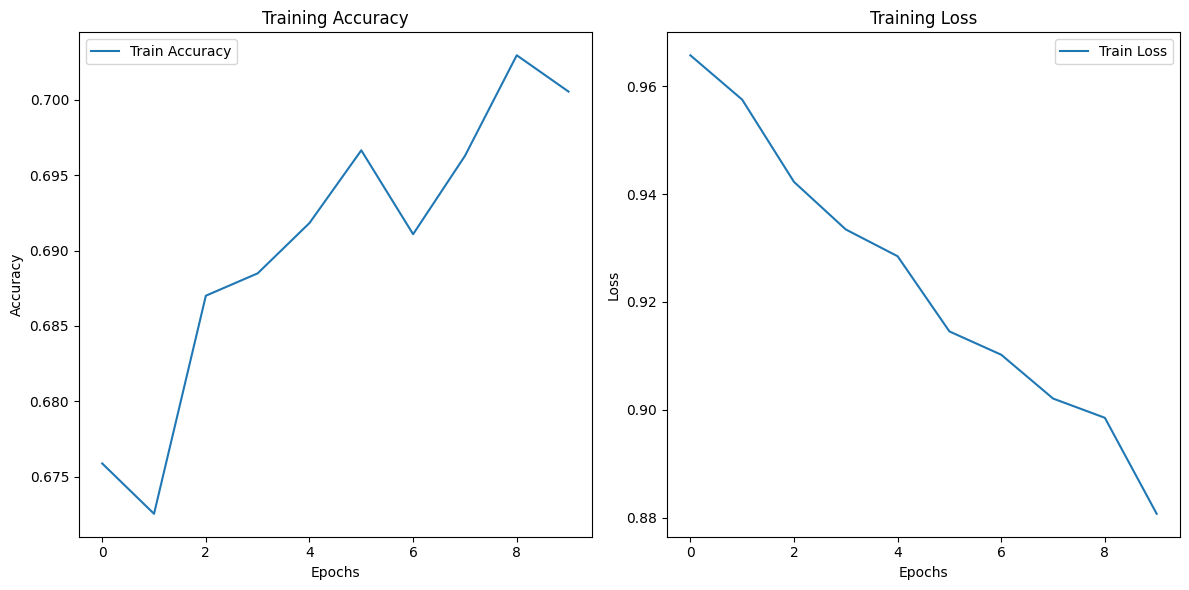

In [ ]:
import matplotlib.pyplot as plt

# Lấy lịch sử huấn luyện
history = model_history.history

# Vẽ biểu đồ accuracy
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Lấy dữ liệu từ model_history
history_dict = model_history.history

# Tạo DataFrame từ history
df = pd.DataFrame(history_dict)

# Xuất ra file CSV
df.to_csv('training_history.csv', index=False)

print("Đã lưu training history vào file 'training_history.csv'")

Đã lưu training history vào file 'training_history.csv'


In [ ]:
from google.colab import files
files.download('training_history.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>